#네이버 영화리뷰 감성분석 도전하기

## 라이브러리 버전을 확인

In [1]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 33.3 MB/s eta 0:00:00


In [2]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.5.3
0.6.0
4.3.1


## 1) 데이터 준비 및 확인

In [5]:
import pandas as pd

# 데이터를 읽어봅시다.
train_data = pd.read_table('./ratings_train.txt')
test_data = pd.read_table('./ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [6]:
from konlpy.tag import Okt # Mecab이 colab상에서 실행되지 않아 okt를 사용
import numpy as np
from collections import Counter

tokenizer = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
  #중복 데이터 삭제
  train_data.drop_duplicates(subset=['document'], inplace=True)
  train_data = train_data.dropna(how = 'any')
  test_data.drop_duplicates(subset=['document'], inplace=True)
  test_data = test_data.dropna(how = 'any')
  X_train = []
  for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)
  X_test = []
  for sentence in test_data['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)
  words = np.concatenate(X_train).tolist()
  counter = Counter(words)
  counter = counter.most_common(10000-4)
  vocab = ['', '', '', ''] + [key for key, _ in counter]
  word_to_index = {word:index for index, word in enumerate(vocab)}

  def wordlist_to_indexlist(wordlist): #사전 구성
      return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))

  return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()} #사전 구성

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
print(index_to_word)

{3: '', 4: '.', 5: '영화', 6: '..', 7: '을', 8: '...', 9: ',', 10: '너무', 11: '?', 12: '다', 13: '정말', 14: '적', 15: '만', 16: '진짜', 17: '!', 18: '로', 19: '점', 20: '에서', 21: '연기', 22: '것', 23: '평점', 24: '내', 25: '~', 26: '최고', 27: '나', 28: '그', 29: '안', 30: '인', 31: '이런', 32: '스토리', 33: '생각', 34: '못', 35: '....', 36: '왜', 37: '드라마', 38: '게', 39: '이다', 40: '감동', 41: '사람', 42: '하는', 43: '1', 44: '보고', 45: '하고', 46: '말', 47: '고', 48: '더', 49: '아', 50: '때', 51: '배우', 52: 'ㅋㅋ', 53: '거', 54: '감독', 55: '그냥', 56: '요', 57: '본', 58: '내용', 59: '재미', 60: '중', 61: '뭐', 62: '까지', 63: '!!', 64: '보다', 65: '없는', 66: '시간', 67: '수', 68: '쓰레기', 69: '지', 70: '네', 71: '봤는데', 72: '작품', 73: '10', 74: '사랑', 75: '할', 76: '없다', 77: '하나', 78: '다시', 79: '볼', 80: '마지막', 81: '이건', 82: '좋은', 83: 'ㅋ', 84: '저', 85: '정도', 86: '같은', 87: '입니다', 88: '완전', 89: '있는', 90: '2', 91: 'ㅋㅋㅋ', 92: '처음', 93: '장면', 94: '액션', 95: '주인공', 96: '대', 97: '걸', 98: '이렇게', 99: '보는', 100: '개', 101: 'ㅠㅠ', 102: '3', 103: "'", 104: '지금', 105: '돈', 106: 

In [11]:
#실제 예시 확인
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[49, 451, 6, 16, 7140, 670]
라벨:  0
1번째 리뷰 문장 길이:  6
2번째 리뷰 문장 길이:  13


## 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  12.806930515667634
문장길이 최대 :  95
문장길이 표준편차 :  10.399093335789471
pad_sequences maxlen :  33
전체 문장의 0.9347442139050574%가 maxlen 설정값 이내에 포함됩니다. 


In [58]:
import numpy as np
import tensorflow as tf

#패딩 추가,maxlen으로 최대 문장 길이 지정
word_to_index["<PAD>"] = 0
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape) #입력문장 개수 146182 입력문장의 최대 길이 33

(146182, 33)


## 4) 모델 구성 및 validation set 구성
 - 3가지 이상 다양하게 구성하여 실험

### 첫번째 모델 RNN

In [14]:
#RNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 예제 코드를 구현
vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다.

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 4)           40000     
                                                                 
 lstm (LSTM)                 (None, 8)                 416       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


### 두번째 모델 1-D CNN

In [ ]:
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu', padding ='same'))
#Conv1D에 padding='same'한 이유는
#벡터의 차원의 수가 적어서 차원이 마이너스로 가벼러서 padding='same'을 주어
#출력길이와 입력길이를 동일하게 했습니다.
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu', padding ='same'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_2.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, None, 4)           40000     
                                                                 
 conv1d_57 (Conv1D)          (None, None, 16)          464       
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, None, 16)         0         
 g1D)                                                            
                                                                 
 conv1d_58 (Conv1D)          (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_30 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_70 (Dense)            (None, 8)               

### 세번째 모델 GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [15]:
vocab_size = 10000  # 어휘 사전의 크기
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 4)           40000     
                                                                 
 global_max_pooling1d (Globa  (None, 4)                0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련

In [77]:
# validation set 40000건 분리
x_val = X_train[:40000]
y_val = y_train[:40000]

# validation set을 제외한 나머지 10000건
partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 33)
(106182,)


In [16]:
#모델 학습 시작 (위의 모델 3가지중 한가지 학습)
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model_3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val,y_val),
                    verbose=1)

Epoch 1/10
286/286 [==============================] - 7s 13ms/step - loss: 0.6453 - accuracy: 0.6740 - val_loss: 0.5630 - val_accuracy: 0.7341
Epoch 2/10
286/286 [==============================] - 3s 10ms/step - loss: 0.5007 - accuracy: 0.7633 - val_loss: 0.4734 - val_accuracy: 0.7755
Epoch 3/10
286/286 [==============================] - 3s 12ms/step - loss: 0.4244 - accuracy: 0.8061 - val_loss: 0.4190 - val_accuracy: 0.8051
Epoch 4/10
286/286 [==============================] - 4s 13ms/step - loss: 0.3750 - accuracy: 0.8336 - val_loss: 0.3988 - val_accuracy: 0.8166
Epoch 5/10
286/286 [==============================] - 2s 7ms/step - loss: 0.3510 - accuracy: 0.8468 - val_loss: 0.3920 - val_accuracy: 0.8217
Epoch 6/10
286/286 [==============================] - 2s 7ms/step - loss: 0.3370 - accuracy: 0.8543 - val_loss: 0.3906 - val_accuracy: 0.8245
Epoch 7/10
286/286 [==============================] - 2s 7ms/step - loss: 0.3275 - accuracy: 0.8592 - val_loss: 0.3913 - val_accuracy: 0.8245
Ep

In [18]:
#테스트셋으로 평가
results = model_3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3962 - accuracy: 0.8239 - 3s/epoch - 2ms/step
[0.3961693346500397, 0.8238908052444458]


## 6) Loss, Accuracy 그래프 시각화

In [19]:
history_dict = history.history

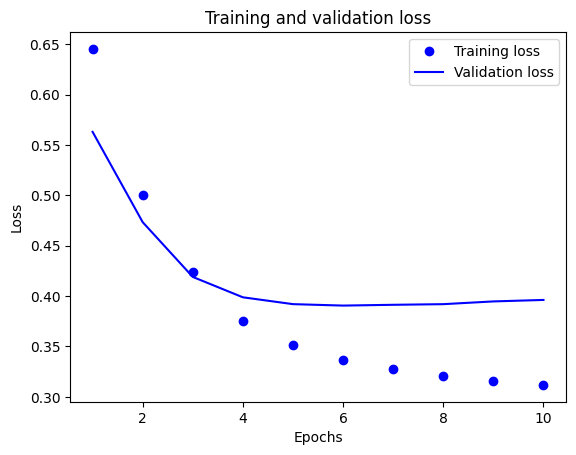

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

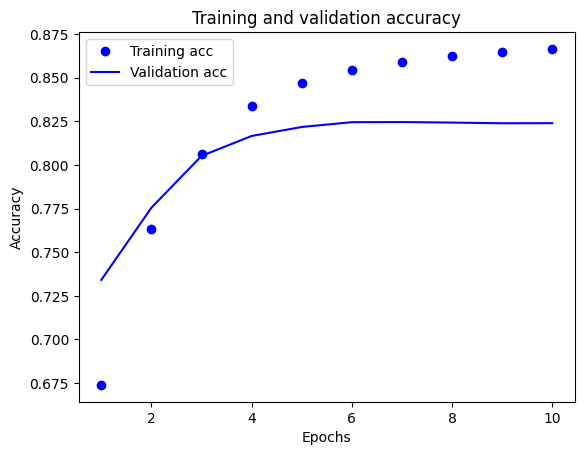

In [21]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 embedding 레이어 분석

In [22]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 4)


In [23]:
print(vocab_size)

10000


In [24]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = './word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [25]:
#gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['오늘']
vector

array([ 0.01519667,  0.03121587,  0.04837071, -0.04892825], dtype=float32)

In [26]:
word_vectors.similar_by_word("안경")

[('놓친', 0.9963969588279724),
 ('미스터', 0.9937812089920044),
 ('나쁘지', 0.9935275912284851),
 ('권리', 0.9913144707679749),
 ('어려운', 0.9909812808036804),
 ('있어야', 0.9892798662185669),
 ('흐른다', 0.9891309142112732),
 ('용의', 0.9881222248077393),
 ('삘', 0.9879395365715027),
 ('생겨서', 0.9840360283851624)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [28]:
#word2vec_ko.model.wv.vectors.npy가 100mb가 넘어서 github에 푸쉬가 되지 않아 lms상에 있는 경로로 지정해야 합니다.
#lms상에 있는 경로로 주석문을 달아놓았습니다.
from gensim.models.keyedvectors import Word2VecKeyedVectors
#word2vec_file_path='~aiffel/aiffel/word2vec_ko.model'
word2vec_file_path= '/content/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [30]:
#Word2Vec 사전 확인
for index, word in enumerate(word_vectors.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(word_vectors.wv.index_to_key)} is {word}")

word #0/302960 is .
word #1/302960 is 의
word #2/302960 is 다
word #3/302960 is 이
word #4/302960 is 는
word #5/302960 is /
word #6/302960 is ="
word #7/302960 is ,
word #8/302960 is 에
word #9/302960 is 을


In [31]:
#사전의 유사도 확인
word_vectors.wv.similar_by_word("안경")

[('두건', 0.7730535268783569),
 ('양복', 0.7350343465805054),
 ('헬멧', 0.734103798866272),
 ('작업복', 0.7330182194709778),
 ('속옷', 0.7198629379272461),
 ('가발', 0.7156580686569214),
 ('선글라스', 0.7086851596832275),
 ('가면', 0.7035356163978577),
 ('양말', 0.6902667284011841),
 ('가운', 0.6873822212219238)]

In [36]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

https://lsjsj92.tistory.com/409

In [74]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen,
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 32
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3)) #dropout 레이어 추가
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3)) #dropout 레이어 추가
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3)) #dropout 레이어 추가
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 33, 100)           1000000   
                                                                 
 lstm_10 (LSTM)              (None, 32)                17024     
                                                                 
 dense_41 (Dense)            (None, 32)                1056      
                                                                 
 dropout_28 (Dropout)        (None, 32)                0         
                                                                 
 dense_42 (Dense)            (None, 16)                528       
                                                                 
 dropout_29 (Dropout)        (None, 16)                0         
                                                                 
 dense_43 (Dense)            (None, 8)               

In [75]:
# 학습의 진행 (잘못 진행) - validation_data를 잘못설정함
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 15 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=1)

Epoch 1/8
286/286 [==============================] - 49s 158ms/step - loss: 0.5872 - accuracy: 0.6780 - val_loss: 0.4199 - val_accuracy: 0.8089
Epoch 2/8
286/286 [==============================] - 42s 146ms/step - loss: 0.4127 - accuracy: 0.8267 - val_loss: 0.3711 - val_accuracy: 0.8340
Epoch 3/8
286/286 [==============================] - 42s 148ms/step - loss: 0.3663 - accuracy: 0.8489 - val_loss: 0.3618 - val_accuracy: 0.8387
Epoch 4/8
286/286 [==============================] - 41s 142ms/step - loss: 0.3447 - accuracy: 0.8596 - val_loss: 0.3666 - val_accuracy: 0.8368
Epoch 5/8
286/286 [==============================] - 41s 143ms/step - loss: 0.3285 - accuracy: 0.8664 - val_loss: 0.3535 - val_accuracy: 0.8437
Epoch 6/8
286/286 [==============================] - 50s 174ms/step - loss: 0.3167 - accuracy: 0.8719 - val_loss: 0.3541 - val_accuracy: 0.8444
Epoch 7/8
286/286 [==============================] - 42s 147ms/step - loss: 0.3069 - accuracy: 0.8748 - val_loss: 0.3651 - val_accuracy:

In [79]:
# 테스트셋을 통한 모델 평가(validation_data를 잘못설정한 평가결과)
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 9s - loss: 0.3589 - accuracy: 0.8448 - 9s/epoch - 6ms/step
[0.3588930368423462, 0.8448237180709839]


In [80]:
# validation set 40000건 분리
x_val = X_train[:40000]
y_val = y_train[:40000]

# validation set을 제외한 나머지 10000건
partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 33)
(106182,)


In [81]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 15 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
208/208 [==============================] - 38s 159ms/step - loss: 0.2869 - accuracy: 0.8846 - val_loss: 0.2611 - val_accuracy: 0.8851
Epoch 2/15
208/208 [==============================] - 37s 178ms/step - loss: 0.2722 - accuracy: 0.8882 - val_loss: 0.2744 - val_accuracy: 0.8777
Epoch 3/15
208/208 [==============================] - 32s 152ms/step - loss: 0.2619 - accuracy: 0.8923 - val_loss: 0.2898 - val_accuracy: 0.8754
Epoch 4/15
208/208 [==============================] - 32s 155ms/step - loss: 0.2513 - accuracy: 0.8961 - val_loss: 0.2931 - val_accuracy: 0.8750
Epoch 5/15
208/208 [==============================] - 32s 152ms/step - loss: 0.2412 - accuracy: 0.8999 - val_loss: 0.3012 - val_accuracy: 0.8706
Epoch 6/15
208/208 [==============================] - 30s 143ms/step - loss: 0.2302 - accuracy: 0.9037 - val_loss: 0.3137 - val_accuracy: 0.8681
Epoch 7/15
208/208 [==============================] - 32s 154ms/step - loss: 0.2186 - accuracy: 0.9085 - val_loss: 0.3491 - val_ac

In [82]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 9s - loss: 0.8927 - accuracy: 0.8289 - 9s/epoch - 6ms/step
[0.8926571607589722, 0.8288748264312744]


In [49]:
print(index_to_word)

{3: '', 4: '.', 5: '영화', 6: '..', 7: '을', 8: '...', 9: ',', 10: '너무', 11: '?', 12: '다', 13: '정말', 14: '적', 15: '만', 16: '진짜', 17: '!', 18: '로', 19: '점', 20: '에서', 21: '연기', 22: '것', 23: '평점', 24: '내', 25: '~', 26: '최고', 27: '나', 28: '그', 29: '안', 30: '인', 31: '이런', 32: '스토리', 33: '생각', 34: '못', 35: '....', 36: '왜', 37: '드라마', 38: '게', 39: '이다', 40: '감동', 41: '사람', 42: '하는', 43: '1', 44: '보고', 45: '하고', 46: '말', 47: '고', 48: '더', 49: '아', 50: '때', 51: '배우', 52: 'ㅋㅋ', 53: '거', 54: '감독', 55: '그냥', 56: '요', 57: '본', 58: '내용', 59: '재미', 60: '중', 61: '뭐', 62: '까지', 63: '!!', 64: '보다', 65: '없는', 66: '시간', 67: '수', 68: '쓰레기', 69: '지', 70: '네', 71: '봤는데', 72: '작품', 73: '10', 74: '사랑', 75: '할', 76: '없다', 77: '하나', 78: '다시', 79: '볼', 80: '마지막', 81: '이건', 82: '좋은', 83: 'ㅋ', 84: '저', 85: '정도', 86: '같은', 87: '입니다', 88: '완전', 89: '있는', 90: '2', 91: 'ㅋㅋㅋ', 92: '처음', 93: '장면', 94: '액션', 95: '주인공', 96: '대', 97: '걸', 98: '이렇게', 99: '보는', 100: '개', 101: 'ㅠㅠ', 102: '3', 103: "'", 104: '지금', 105: '돈', 106: 

In [50]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = './word2vec.ko.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [51]:
#gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['금요일']
vector

array([ 3.601068  , -2.949727  ,  2.3178017 ,  1.7649785 ,  1.5867155 ,
       -0.80973184,  0.92595047, -0.13071379, -0.66139066, -1.3367276 ,
        1.5200424 ,  1.3324243 , -0.46805826, -1.985169  , -0.20040794,
        0.38341534,  1.4402049 ,  2.32215   ,  0.15325864, -1.7591729 ,
        1.7535921 ,  0.8392615 ,  0.3983316 , -0.04806901,  0.98593193,
       -0.6490713 , -0.82294345, -0.85699993, -3.4821837 , -1.6350983 ,
       -1.5258687 ,  1.0313336 ,  0.877815  ,  1.5778872 ,  2.7535107 ,
        2.4806974 , -1.7222407 ,  0.9814756 , -2.0568237 , -0.28270176,
        0.8945673 ,  1.2399217 ,  2.0773556 ,  2.4001138 , -1.0933131 ,
        1.2385424 , -0.29549393,  4.574128  ,  2.1729085 ,  0.82170165,
       -0.7103115 ,  0.23624235, -0.73759574, -1.4727212 ,  0.06539751,
       -1.4923751 ,  2.6144621 ,  1.3230913 ,  3.7711968 ,  0.93653756,
        0.62050205,  2.370044  , -0.29782102, -1.2301348 , -0.04075687,
       -2.98223   , -0.69982624, -2.3286257 ,  2.0759306 ,  0.62

In [52]:
word_vectors.similar_by_word("금요일")

[('토요일', 0.9107511639595032),
 ('월요일', 0.9027431607246399),
 ('일요일', 0.8979982733726501),
 ('매주', 0.8131237030029297),
 ('저녁', 0.7764228582382202),
 ('아침', 0.7513717412948608),
 ('주말', 0.7480690479278564),
 ('밤', 0.7149110436439514),
 ('새벽', 0.7057705521583557),
 ('추석', 0.6522760987281799)]

회고

마지막 모델에 globalmaxpooling1d를 넣어줬을 때, 정확도가 떨어져서 위의 모델에서 제외  
model.add(tf.keras.layers.GlobalMaxPooling1D()) - GlobalMaxPooling1
model.add(tf.keras.layers.Dense(4, activation='relu')) 를 추가했을 때, 정확도가 감소하여 추가하지 않았음  
dropout의 rating을 0.2 , 0.3 , 0.4, 0.5 로 설정했을 때 0.3이 정확도가 가장 높았음
그런데, validation_data를 잘못 지정하여 마지막에 추가하여 위에 실험했던 것들이 무용지물이 되어 아쉬웠다.  
아직 레이어에 대한 파라미터를 정확하게 알지 못하여 실험할 수 있는 경우의 수가 한정되어 아쉬웠다. 좀 더 배워서 성능을 좀 더 올릴 수 있